# ML-based analysis of particle distributions in high-intensity laser experiments. Reconstruction of the peak amplitude of a laser pulse.

This file shows the restoration of peak amplitude using machine learning methods.4 methods of machine learning for prediction. Namely:

1. Support vector machine.
2. Gradient boosting tree.
3. Fully connected neural network.
4. Convolutional neural network.

Also, dimensionality reduction have been tested.  To reduce the dimension, the principal component method will be used.

## -1. Importing the required libraries

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.display import HTML, display

In [3]:
from sklearn.svm import SVR
import xgboost as xgb

from sklearn import preprocessing
from sklearn import metrics

from sklearn.decomposition import PCA

In [4]:
import tensorflow as tf
import random as python_random

from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.models import Sequential
from keras import losses as kl
from keras import optimizers as opts
from keras import initializers

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 0. Secondary functions

Defining functions for reading data. Also, functions for transforming over features and labels, to improve model machine learning. Display the results of the accuracy of the models, a table with metrics will be built. We will count three metrics: mean absolute error, mean relative percentage error, coefficient of determination.

In [6]:
def read(file):
    h5f = h5py.File(file, 'r')

    x_train = np.asarray(h5f['x_train'])
    y_train = np.asarray(h5f['y_train'])
    
    x_test = np.asarray(h5f['x_test'])
    y_test = np.asarray(h5f['y_test'])
    
    x_valid = np.asarray(h5f['x_valid'])
    y_valid = np.asarray(h5f['y_valid'])
    
    h5f.close()

    return x_train, y_train.ravel(), x_test, y_test.ravel(), x_valid, y_valid.ravel()

In [7]:
def scaler_minmax(x_train, x_test, x_valid):
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(x_train)

    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    x_valid = scaler.transform(x_valid)
    
    return x_train, x_test, x_valid


def scaler_label(y_train, y_test, y_valid):
    
    y_train /= 1000
    y_test /= 1000
    y_valid /= 1000
    
    return y_train, y_test, y_valid

In [8]:
def data_to_table(data, columns=None):
    if len(data) == 0 :
        display(HTML('<b>No data</b>'))
        return
    
    hdr = ''
    if columns != None:
        for col in columns:
            hdr = hdr + '<th>' + col + '</th>'
            
        hdr = '<tr>' + hdr + '</tr>'

    dt = ''
    for row in data:
        dt = dt + '<tr>'
        for cell in row:
            dt = dt + '<td>' + str(cell) + '</td>'
        dt = dt + '</tr>'
            
    display(HTML('<table>' + hdr + dt + '</table>'))

In [9]:
def calculate_mpre(y_test, y_pred):
    """Calculate mean relative percentage error."""
    mrpe = 0.0
        
    for k in range(y_test.shape[0]):
        mrpe += np.abs(y_test[k] - y_pred[k]) / np.abs(y_test[k])
    mrpe = mrpe * 100 / y_test.shape[0]

    return mrpe


def regression_metrics(name, y_test, y_valid, y_pred_test, y_pred_valid, scaler=1000):  
    y_test *= scaler
    y_valid *= scaler
    
    y_pred_test *= scaler
    y_pred_valid *= scaler
    
    mae_t = metrics.mean_absolute_error(y_test, y_pred_test).round(3)
    mrpe_t = calculate_mpre(y_test, y_pred_test).round(3)
    R2_t = metrics.r2_score(y_test, y_pred_test).round(5)

    mae_v = metrics.mean_absolute_error(y_valid, y_pred_valid).round(3)
    mrpe_v = calculate_mpre(y_valid, y_pred_valid).round(3)
    R2_v = metrics.r2_score(y_valid, y_pred_valid).round(5)
    
    tabledata = [["Mean absolute error", mae_v, mae_t],
         ["Mean relative percentage error", mrpe_v, mrpe_t],
         ["Coefficient of determination", R2_v, R2_t]]
    
    print(f"Method: {name}")
    data_to_table(tabledata, columns=["Measure", "validation data", "test data"])
    
    return [mae_t, mrpe_t, R2_t]

## 1. Loading data

Let's load the data for all models, and also perform the transformation on the data. We will scale the feature and label in the range from 0 to 1.

In [10]:
file_svm = "data/data_svm.h5"
file_xgb = "data/data_xgb.h5"
file_fnn = "data/data_fnn.h5"
file_cnn = "data/data_cnn.h5"

x_train_svm, y_train_svm, x_test_svm, y_test_svm, x_valid_svm, y_valid_svm = read(file_svm)
x_train_xgb, y_train_xgb, x_test_xgb, y_test_xgb, x_valid_xgb, y_valid_xgb = read(file_xgb)
x_train_fnn, y_train_fnn, x_test_fnn, y_test_fnn, x_valid_fnn, y_valid_fnn = read(file_fnn)
x_train_cnn, y_train_cnn, x_test_cnn, y_test_cnn, x_valid_cnn, y_valid_cnn = read(file_cnn)

x_train_svm, x_test_svm, x_valid_svm = scaler_minmax(x_train_svm, x_test_svm, x_valid_svm)
x_train_xgb, x_test_xgb, x_valid_xgb = scaler_minmax(x_train_xgb, x_test_xgb, x_valid_xgb)
x_train_fnn, x_test_fnn, x_valid_fnn = scaler_minmax(x_train_fnn, x_test_fnn, x_valid_fnn)
x_train_cnn, x_test_cnn, x_valid_cnn = scaler_minmax(x_train_cnn, x_test_cnn, x_valid_cnn)

y_train_svm, y_test_svm, y_valid_svm = scaler_label(y_train_svm, y_test_svm, y_valid_svm)
y_train_xgb, y_test_xgb, y_valid_xgb = scaler_label(y_train_xgb, y_test_xgb, y_valid_xgb)
y_train_fnn, y_test_fnn, y_valid_fnn = scaler_label(y_train_fnn, y_test_fnn, y_valid_fnn)
y_train_cnn, y_test_cnn, y_valid_cnn = scaler_label(y_train_cnn, y_test_cnn, y_valid_cnn)

Output layer dimension for all neural networks.

In [11]:
output_dim_nn = 1

Below, for each method, we present the best results achieved with the best choice of hyperparameters. There was no desire to get the best result on this task. It was necessary to demonstrate the possibility of solving the problem with high accuracy using machine learning methods.

## 2. Support vector machine

In [12]:
regressor = SVR(kernel='rbf', C=30.0, epsilon=0.0003)
regressor.fit(x_train_svm, y_train_svm)
None

In [13]:
y_pred_t_svm = regressor.predict(x_test_svm)
y_pred_v_svm = regressor.predict(x_valid_svm)

In [14]:
metric_svm = regression_metrics("Support vector regression", 
                   y_test_svm.copy(), y_valid_svm.copy(),
                   y_pred_t_svm.copy(),y_pred_v_svm.copy())

Method: Support vector regression


Measure,validation data,test data
Mean absolute error,4.212,4.05
Mean relative percentage error,1.113,1.062
Coefficient of determination,0.99936,0.9993


## 3. Gradient boosting tree

In [15]:
xgbr = xgb.XGBRegressor(learning_rate = 0.10, max_depth = 6,
                        reg_lambda = 0.0, n_estimators = 110,
                        booster='gbtree', verbosity=0, random_state=42)
xgbr.fit(x_train_xgb, y_train_xgb)
None

In [16]:
y_pred_t_xgb = xgbr.predict(x_test_xgb)
y_pred_v_xgb = xgbr.predict(x_valid_xgb)

In [17]:
metric_xgb = regression_metrics("Gradient boosting tree", 
                   y_test_xgb.copy(), y_valid_xgb.copy(),
                   y_pred_t_xgb.copy(),y_pred_v_xgb.copy())

Method: Gradient boosting tree


Measure,validation data,test data
Mean absolute error,2.622,2.453
Mean relative percentage error,0.782,0.661
Coefficient of determination,0.99957,0.99967


## 4. Fully connected neural network

In [18]:
def compile_fnn(output_dim):
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(1234)
    
    model = Sequential()

    model.add(Dense(100, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(75, activation="sigmoid", kernel_initializer=initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(64, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(16, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(4, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    
    model.add(Dense(output_dim))

    opt = opts.Adam(learning_rate=0.001)
    model.compile(loss=kl.mean_absolute_error, optimizer=opt)

    return model


def train_fnn(model, x_train, y_train, initial_epoch=0, epoch=10,
              validation_data=None, batch_size=64, shuffle=True, verbose=0):
    
    history = model.fit(x_train, y_train, initial_epoch=initial_epoch, epochs=epoch,
                        validation_data=validation_data, batch_size=batch_size, 
                        shuffle=shuffle, verbose=verbose)

    return model, history


def predict_fnn(model, x_data):
    y_pred = model.predict(x_data)

    return y_pred

In [19]:
model_fnn = compile_fnn(output_dim=output_dim_nn)

model_fnn, history = train_fnn(model_fnn, x_train_fnn, y_train_fnn,
                               epoch=1420, validation_data=(x_valid_fnn, y_valid_fnn),
                               batch_size=32, verbose=1)

Epoch 1/1420
93/93 [==============================] - 0s 3ms/step - loss: 0.1429 - val_loss: 0.0423
Epoch 2/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0276
Epoch 3/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0183
Epoch 4/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0177
Epoch 5/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0196 - val_loss: 0.0136
Epoch 6/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0191 - val_loss: 0.0184
Epoch 7/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0188 - val_loss: 0.0177
Epoch 8/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0149 - val_loss: 0.0127
Epoch 9/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0156 - val_loss: 0.0121
Epoch 10/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0136 - val_loss: 0.0132

93/93 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 83/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 84/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 85/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 86/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 87/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0063
Epoch 88/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 89/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 90/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 91/1420
93/93 [==============================] - 0s 997us/step - loss: 0.0045 - val_loss: 0.0040
Ep

93/93 [==============================] - 0s 965us/step - loss: 0.0033 - val_loss: 0.0028
Epoch 162/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0041 - val_loss: 0.0059
Epoch 163/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0042 - val_loss: 0.0033
Epoch 164/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 165/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0037 - val_loss: 0.0047
Epoch 166/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0038 - val_loss: 0.0028
Epoch 167/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0046 - val_loss: 0.0035
Epoch 168/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0042 - val_loss: 0.0047
Epoch 169/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0033 - val_loss: 0.0042
Epoch 170/1420
93/93 [==============================] - 0s 944us/step - loss: 0

93/93 [==============================] - 0s 954us/step - loss: 0.0029 - val_loss: 0.0027
Epoch 241/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0038 - val_loss: 0.0032
Epoch 242/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0032 - val_loss: 0.0051
Epoch 243/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0036 - val_loss: 0.0023
Epoch 244/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 245/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 246/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0029 - val_loss: 0.0031
Epoch 247/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0031 - val_loss: 0.0021
Epoch 248/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0028 - val_loss: 0.0033
Epoch 249/1420
93/93 [==============================] - 0s 976us/step - loss: 0

Epoch 319/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0036 - val_loss: 0.0025
Epoch 320/1420
93/93 [==============================] - 0s 933us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 321/1420
93/93 [==============================] - 0s 933us/step - loss: 0.0032 - val_loss: 0.0020
Epoch 322/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0029 - val_loss: 0.0034
Epoch 323/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0027 - val_loss: 0.0021
Epoch 324/1420
93/93 [==============================] - 0s 997us/step - loss: 0.0030 - val_loss: 0.0023
Epoch 325/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 326/1420
93/93 [==============================] - 0s 944us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 327/1420
93/93 [==============================] - 0s 922us/step - loss: 0.0026 - val_loss: 0.0034
Epoch 328/1420
93/93 [==============================] - 0s 890us

93/93 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 399/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 400/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 401/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 402/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0029 - val_loss: 0.0021
Epoch 403/1420
93/93 [==============================] - 0s 944us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 404/1420
93/93 [==============================] - 0s 922us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 405/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 406/1420
93/93 [==============================] - 0s 922us/step - loss: 0.0025 - val_loss: 0.0033
Epoch 407/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0032 - 

Epoch 477/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0027 - val_loss: 0.0031
Epoch 478/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0025 - val_loss: 0.0020
Epoch 479/1420
93/93 [==============================] - 0s 912us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 480/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 481/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0035 - val_loss: 0.0027
Epoch 482/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 483/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 484/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 485/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 486/1420
93/93 [==============================] - 0s 1ms/ste

Epoch 556/1420
93/93 [==============================] - 0s 944us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 557/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 558/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 559/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 560/1420
93/93 [==============================] - 0s 955us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 561/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 562/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 563/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0025 - val_loss: 0.0032
Epoch 564/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 565/1420
93/93 [==============================] - 0s 965us

93/93 [==============================] - 0s 965us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 636/1420
93/93 [==============================] - 0s 944us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 637/1420
93/93 [==============================] - 0s 944us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 638/1420
93/93 [==============================] - 0s 912us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 639/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 640/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 641/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0026 - val_loss: 0.0021
Epoch 642/1420
93/93 [==============================] - 0s 997us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 643/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 644/1420
93/93 [==============================] - 0s 997us/step - loss: 0

93/93 [==============================] - 0s 997us/step - loss: 0.0021 - val_loss: 0.0026
Epoch 715/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 716/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 717/1420
93/93 [==============================] - 0s 997us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 718/1420
93/93 [==============================] - 0s 997us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 719/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 720/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 721/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 722/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 723/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0

93/93 [==============================] - 0s 933us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 794/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 795/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 796/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0022 - val_loss: 0.0030
Epoch 797/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 798/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 799/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0022 - val_loss: 0.0027
Epoch 800/1420
93/93 [==============================] - 0s 997us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 801/1420
93/93 [==============================] - 0s 933us/step - loss: 0.0020 - val_loss: 0.0031
Epoch 802/1420
93/93 [==============================] - 0s 987us/step - loss: 0

93/93 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 873/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 874/1420
93/93 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 875/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 876/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 877/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 878/1420
93/93 [==============================] - 0s 997us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 879/1420
93/93 [==============================] - 0s 960us/step - loss: 0.0022 - val_loss: 0.0028
Epoch 880/1420
93/93 [==============================] - 0s 922us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 881/1420
93/93 [==============================] - 0s 922us/step - loss: 0.0023 - val_

93/93 [==============================] - 0s 965us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 952/1420
93/93 [==============================] - 0s 998us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 953/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 954/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 955/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 956/1420
93/93 [==============================] - 0s 997us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 957/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 958/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 959/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 960/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0

93/93 [==============================] - 0s 965us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 1030/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 1031/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 1032/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1033/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 1034/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 1035/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 1036/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 1037/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1038/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.00

93/93 [==============================] - 0s 976us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1108/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 1109/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 1110/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1111/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 1112/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1113/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1114/1420
93/93 [==============================] - 0s 997us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1115/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 1116/1420
93/93 [==============================] - 0s 997us/step 

93/93 [==============================] - 0s 965us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 1186/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0020 - val_loss: 0.0029
Epoch 1187/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 1188/1420
93/93 [==============================] - 0s 986us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 1189/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 1190/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 1191/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 1192/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 1193/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0025 - val_loss: 0.0020
Epoch 1194/1420
93/93 [==============================] - 0s 1ms/step - loss

93/93 [==============================] - 0s 976us/step - loss: 0.0022 - val_loss: 0.0028
Epoch 1264/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0021 - val_loss: 0.0028
Epoch 1265/1420
93/93 [==============================] - 0s 987us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 1266/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 1267/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1268/1420
93/93 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 1269/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 1270/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 1271/1420
93/93 [==============================] - 0s 976us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 1272/1420
93/93 [==============================] - 0s 976us/step - 

93/93 [==============================] - 0s 901us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 1342/1420
93/93 [==============================] - 0s 890us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 1343/1420
93/93 [==============================] - 0s 912us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 1344/1420
93/93 [==============================] - 0s 912us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1345/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 1346/1420
93/93 [==============================] - 0s 944us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 1347/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 1348/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1349/1420
93/93 [==============================] - 0s 954us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 1350/1420
93/93 [==============================] - 0s 954us/step 

93/93 [==============================] - 0s 976us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1420/1420
93/93 [==============================] - 0s 965us/step - loss: 0.0022 - val_loss: 0.0018


In [20]:
y_pred_t_fnn = predict_fnn(model_fnn, x_test_fnn)
y_pred_v_fnn = predict_fnn(model_fnn, x_valid_fnn)

y_pred_t_fnn = y_pred_t_fnn.reshape((y_pred_t_fnn.shape[0],))
y_pred_v_fnn = y_pred_v_fnn.reshape((y_pred_t_fnn.shape[0],))

In [21]:
metric_fnn = regression_metrics("Fully connected neural network", 
                   y_test_fnn.copy(), y_valid_fnn.copy(),
                   y_pred_t_fnn.copy(), y_pred_v_fnn.copy())

Method: Fully connected neural network


Measure,validation data,test data
Mean absolute error,1.796,1.784
Mean relative percentage error,0.504,0.512
Coefficient of determination,0.99992,0.99993


## 5. Convolutional neural network

In [22]:
def compile_cnn(output_dim):
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(1234)

    model = Sequential()

    model.add(Conv1D(1, (3), activation='relu'))
    model.add(Conv1D(3, (3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))

    model.add(Conv1D(3, (3), activation='relu'))
    model.add(Conv1D(9, (3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))

    model.add(Flatten())

    model.add(Dense(96, activation="sigmoid", kernel_initializer=initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(value=0.00)))
    model.add(Dense(64, activation="sigmoid", kernel_initializer=initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(value=0.00)))
    model.add(Dense(16, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.00)))
    model.add(Dense(4, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.00)))

    model.add(Dense(output_dim, name="output"))

    opt = opts.Adam(learning_rate=0.0003)
    model.compile(loss=kl.mean_absolute_error, optimizer=opt)

    return model


def train_cnn(model, x_train, y_train, initial_epoch=0, epoch=10,
              validation_data=None, batch_size=64, shuffle=True, verbose=0):

    history = model.fit(x_train, y_train, initial_epoch=initial_epoch, epochs=epoch,
                        validation_data=validation_data, batch_size=batch_size,
                        shuffle=shuffle, verbose=verbose)

    return model, history


def predict_cnn(model, x_data):
    y_pred = model.predict(x_data)

    return y_pred

In [23]:
x_train_cnn = np.reshape(x_train_cnn, (x_train_cnn.shape[0], x_train_cnn.shape[1], 1))
x_test_cnn = np.reshape(x_test_cnn, (x_test_cnn.shape[0], x_test_cnn.shape[1], 1))
x_valid_cnn = np.reshape(x_valid_cnn, (x_valid_cnn.shape[0], x_valid_cnn.shape[1], 1))

In [24]:
model_cnn = compile_cnn(output_dim=output_dim_nn)

model_cnn, history  = train_cnn(model_cnn, x_train_cnn, y_train_cnn,
                                epoch=1520, validation_data=(x_valid_cnn, y_valid_cnn), 
                                batch_size=32, verbose=1)

Epoch 1/1520
93/93 [==============================] - 1s 6ms/step - loss: 0.2567 - val_loss: 0.2479
Epoch 2/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.2481 - val_loss: 0.2479
Epoch 3/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.2470 - val_loss: 0.2450
Epoch 4/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.2380 - val_loss: 0.2210
Epoch 5/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.1792 - val_loss: 0.1528
Epoch 6/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.1467 - val_loss: 0.1413
Epoch 7/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.1335 - val_loss: 0.1277
Epoch 8/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.1073 - val_loss: 0.0882
Epoch 9/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0754 - val_loss: 0.0611
Epoch 10/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0524 - val_loss: 0.0422

93/93 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0065
Epoch 83/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 84/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0056
Epoch 85/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 86/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 87/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 88/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 89/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 90/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 91/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0056
Epoc

93/93 [==============================] - 1s 5ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 163/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 164/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 165/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 166/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 167/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 168/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 169/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 170/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 171/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 243/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 244/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 245/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 246/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 247/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 248/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 249/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 250/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 251/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 323/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 324/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 325/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 326/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 327/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 328/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 329/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 330/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 331/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 403/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 404/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 405/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 406/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 407/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 408/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 409/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 410/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 411/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 483/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 484/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 485/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 486/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 487/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 488/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 489/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 490/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 491/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 563/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 564/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 565/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 566/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 567/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 568/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 569/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 570/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 571/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 643/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 644/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 645/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 646/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 647/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 648/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 649/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 650/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 651/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 723/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 724/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 725/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 726/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 727/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 728/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 729/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 730/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 731/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 803/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 804/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 805/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 806/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 807/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 808/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 809/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 810/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 811/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 883/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 884/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 885/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 886/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 887/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 888/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 889/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 890/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 891/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 963/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 964/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 965/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 966/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 967/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 968/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 969/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 970/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 971/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.

93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1043/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 1044/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1045/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 1046/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 1047/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1048/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1049/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1050/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 1051/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val

93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 1122/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 1123/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 1124/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 1125/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 1126/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 1127/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1128/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1129/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 1130/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val

93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 1201/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 1202/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1203/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 1204/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 1205/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 1206/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 1207/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 1208/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1209/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val

93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 1280/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1281/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1282/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 1283/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 1284/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1285/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 1286/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 1287/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 1288/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val

93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 1359/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 1360/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1361/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 1362/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1363/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 1364/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1365/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 1366/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 1367/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val

93/93 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 1438/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 1439/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 1440/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1441/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 1442/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1443/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 1444/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 1445/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1446/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0020 - val

93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 1517/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 1518/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1519/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 1520/1520
93/93 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0018


In [25]:
y_pred_t_cnn = predict_cnn(model_cnn, x_test_cnn)
y_pred_v_cnn = predict_cnn(model_cnn, x_valid_cnn)

y_pred_t_cnn = y_pred_t_cnn.reshape((y_pred_t_cnn.shape[0],))
y_pred_v_cnn = y_pred_v_cnn.reshape((y_pred_v_cnn.shape[0],))

In [26]:
metric_cnn = regression_metrics("Convolutional neural network", 
                   y_test_cnn.copy(), y_valid_cnn.copy(),
                   y_pred_t_cnn.copy(), y_pred_v_cnn.copy())

Method: Convolutional neural network


Measure,validation data,test data
Mean absolute error,1.796,1.827
Mean relative percentage error,0.477,0.496
Coefficient of determination,0.99992,0.99992


## 6. Dimension reduction

To reduce the dimension, the principal component method will be used. After the dimensionality reduction, we will use a fully connected neural network as a machine learning method, since it has proven itself well. 

First, let's see how much of the variance each component retains. The components after 6 explain the very low percentage of variance. As it seems, components with 1-4 should definitely be stay, but 5 and 6 are not obvious.

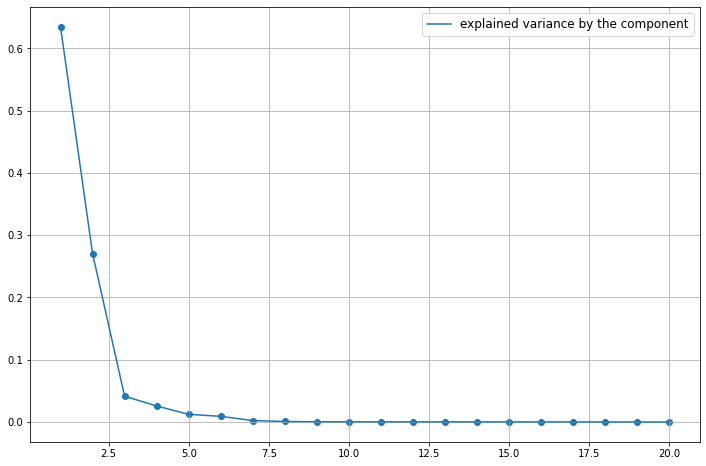

In [27]:
plt.rcParams['figure.figsize'] = (12, 8)

pca = PCA(n_components=20)
pca.fit(x_train_fnn)

plt.plot(range(1, 21), pca.explained_variance_ratio_, label='explained variance by the component')
plt.scatter(range(1, 21), pca.explained_variance_ratio_)

plt.grid()
plt.legend(fontsize=12)

As we can see, the fifth component retains almost a percentage of the variance of the original data. While the sixth is 4 times less and retains 0.2 percent of variance only. We will not take it.

In [28]:
print(f"component 5: {np.round(pca.explained_variance_ratio_[5]* 100, 3)}, " 
      f"component 6: {np.round(pca.explained_variance_ratio_[6]* 100, 3)}")

component 5: 0.915, component 6: 0.235


In [29]:
pca = PCA(n_components=5)
pca.fit(x_train_fnn)

x_train_pca = pca.transform(x_train_fnn)
x_test_pca = pca.transform(x_test_fnn)
x_valid_pca = pca.transform(x_valid_fnn)

y_train_pca = y_train_fnn.copy()
y_test_pca = y_test_fnn.copy()
y_valid_pca = y_valid_fnn.copy()

Five principal components explain 98 percent of the variance in the original data.

In [30]:
np.sum(pca.explained_variance_ratio_)

0.9847676620588585

In [31]:
def compile_pca(output_dim):
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(1234)
    
    model = Sequential()

    model.add(Dense(10, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(10, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(10, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(8, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(4, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))

    model.add(Dense(output_dim, name="output"))

    opt = opts.Adam(learning_rate=0.0006)
    model.compile(loss=kl.mean_absolute_error, optimizer=opt)

    return model


def train_pca(model, x_train, y_train, initial_epoch=0, epoch=10,
              validation_data=None, batch_size=8, shuffle=True, verbose=0):

    history = model.fit(x_train, y_train, initial_epoch=initial_epoch, epochs=epoch,
                        validation_data=validation_data, batch_size=batch_size,
                        shuffle=shuffle, verbose=verbose)

    return model, history


def predict_pca(model, x_data):
    y_pred = model.predict(x_data)

    return y_pred

In [32]:
model_pca = compile_pca(output_dim=output_dim_nn)

model_pca, history  = train_pca(model_pca, x_train_pca, y_train_pca,
                                epoch=2800, validation_data=(x_valid_pca, y_valid_pca), 
                                batch_size=32, verbose=1)

Epoch 1/2800
93/93 [==============================] - 0s 2ms/step - loss: 0.2554 - val_loss: 0.1446
Epoch 2/2800
93/93 [==============================] - 0s 965us/step - loss: 0.1088 - val_loss: 0.0793
Epoch 3/2800
93/93 [==============================] - 0s 966us/step - loss: 0.0649 - val_loss: 0.0542
Epoch 4/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0473 - val_loss: 0.0421
Epoch 5/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0379 - val_loss: 0.0337
Epoch 6/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0314 - val_loss: 0.0300
Epoch 7/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0288 - val_loss: 0.0281
Epoch 8/2800
93/93 [==============================] - 0s 944us/step - loss: 0.0267 - val_loss: 0.0262
Epoch 9/2800
93/93 [==============================] - 0s 955us/step - loss: 0.0241 - val_loss: 0.0241
Epoch 10/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0232 

Epoch 81/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 82/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0074 - val_loss: 0.0071
Epoch 83/2800
93/93 [==============================] - 0s 997us/step - loss: 0.0073 - val_loss: 0.0068
Epoch 84/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 85/2800
93/93 [==============================] - 0s 998us/step - loss: 0.0072 - val_loss: 0.0066
Epoch 86/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0074 - val_loss: 0.0069
Epoch 87/2800
93/93 [==============================] - 0s 997us/step - loss: 0.0071 - val_loss: 0.0074
Epoch 88/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0067 - val_loss: 0.0062
Epoch 89/2800
93/93 [==============================] - 0s 997us/step - loss: 0.0070 - val_loss: 0.0083
Epoch 90/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.

93/93 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0073
Epoch 161/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 162/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 163/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 164/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 165/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 166/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 167/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 168/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 169/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.

93/93 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 241/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 242/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 243/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 244/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 245/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 246/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 247/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 248/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 249/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.

93/93 [==============================] - 0s 997us/step - loss: 0.0039 - val_loss: 0.0041
Epoch 320/2800
93/93 [==============================] - 0s 997us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 321/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0034 - val_loss: 0.0035
Epoch 322/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0037 - val_loss: 0.0042
Epoch 323/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0036 - val_loss: 0.0031
Epoch 324/2800
93/93 [==============================] - 0s 997us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 325/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 326/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 327/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 328/2800
93/93 [==============================] - 0s 976us/step - loss: 0

Epoch 398/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 399/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 400/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 401/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 402/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 403/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 404/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 405/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 406/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 407/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.00

93/93 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 479/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 480/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 481/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 482/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 483/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 484/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 485/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 486/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 487/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.

93/93 [==============================] - 0s 923us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 558/2800
93/93 [==============================] - 0s 954us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 559/2800
93/93 [==============================] - 0s 911us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 560/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0031 - val_loss: 0.0037
Epoch 561/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 562/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 563/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 564/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 565/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 566/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0

Epoch 636/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0028 - val_loss: 0.0031
Epoch 637/2800
93/93 [==============================] - 0s 783us/step - loss: 0.0029 - val_loss: 0.0031
Epoch 638/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 639/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 640/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 641/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0025 - val_loss: 0.0033
Epoch 642/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 643/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 644/2800
93/93 [==============================] - 0s 954us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 645/2800
93/93 [==============================] - 0s 954us

Epoch 715/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 716/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 717/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 718/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 719/2800
93/93 [==============================] - 0s 923us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 720/2800
93/93 [==============================] - 0s 911us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 721/2800
93/93 [==============================] - 0s 954us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 722/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 723/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 724/2800
93/93 [==============================] - 0s 922us

Epoch 794/2800
93/93 [==============================] - 0s 944us/step - loss: 0.0028 - val_loss: 0.0032
Epoch 795/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 796/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0026 - val_loss: 0.0044
Epoch 797/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 798/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 799/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 800/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 801/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0028 - val_loss: 0.0044
Epoch 802/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0027 - val_loss: 0.0031
Epoch 803/2800
93/93 [==============================] - 0s 987us

Epoch 873/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 874/2800
93/93 [==============================] - 0s 997us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 875/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 876/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0024 - val_loss: 0.0028
Epoch 877/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0025 - val_loss: 0.0034
Epoch 878/2800
93/93 [==============================] - 0s 966us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 879/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 880/2800
93/93 [==============================] - ETA: 0s - loss: 0.002 - 0s 976us/step - loss: 0.0025 - val_loss: 0.0034
Epoch 881/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 882/2800
93/93 [==================

93/93 [==============================] - 0s 987us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 952/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 953/2800
93/93 [==============================] - 0s 997us/step - loss: 0.0027 - val_loss: 0.0032
Epoch 954/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 955/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 956/2800
93/93 [==============================] - 0s 955us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 957/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 958/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 959/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 960/2800
93/93 [==============================] - 0s 997us/step - loss: 0

93/93 [==============================] - 0s 987us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1030/2800
93/93 [==============================] - 0s 954us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 1031/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1032/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1033/2800
93/93 [==============================] - 0s 997us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 1034/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 1035/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 1036/2800
93/93 [==============================] - 0s 987us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 1037/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 1038/2800
93/93 [==============================] - 0s 954us/step 

93/93 [==============================] - 0s 976us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 1108/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1109/2800
93/93 [==============================] - 0s 954us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1110/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 1111/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1112/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 1113/2800
93/93 [==============================] - 0s 997us/step - loss: 0.0024 - val_loss: 0.0028
Epoch 1114/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 1115/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 1116/2800
93/93 [==============================] - 0s 966us/step 

Epoch 1185/2800
93/93 [==============================] - 0s 944us/step - loss: 0.0024 - val_loss: 0.0034
Epoch 1186/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1187/2800
93/93 [==============================] - 0s 943us/step - loss: 0.0022 - val_loss: 0.0027
Epoch 1188/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 1189/2800
93/93 [==============================] - 0s 944us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 1190/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 1191/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 1192/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0026 - val_loss: 0.0031
Epoch 1193/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1194/2800
93/93 [==============================] - 

93/93 [==============================] - 0s 879us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 1264/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0026 - val_loss: 0.0030
Epoch 1265/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 1266/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 1267/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1268/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 1269/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1270/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 1271/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1272/2800
93/93 [==============================] - 0s 933us/step 

93/93 [==============================] - 0s 858us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1342/2800
93/93 [==============================] - 0s 836us/step - loss: 0.0023 - val_loss: 0.0029
Epoch 1343/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 1344/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1345/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1346/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 1347/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1348/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 1349/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 1350/2800
93/93 [==============================] - 0s 890us/step 

93/93 [==============================] - 0s 847us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1420/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0025 - val_loss: 0.0029
Epoch 1421/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 1422/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0023 - val_loss: 0.0029
Epoch 1423/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0026 - val_loss: 0.0030
Epoch 1424/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0026 - val_loss: 0.0042
Epoch 1425/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 1426/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 1427/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 1428/2800
93/93 [==============================] - 0s 890us/step - 

93/93 [==============================] - 0s 858us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 1498/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1499/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 1500/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1501/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 1502/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1503/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1504/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 1505/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 1506/2800
93/93 [==============================] - 0s 912us/step - 

93/93 [==============================] - 0s 847us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 1576/2800
93/93 [==============================] - 0s 836us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 1577/2800
93/93 [==============================] - 0s 836us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 1578/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 1579/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 1580/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 1581/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 1582/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0025 - val_loss: 0.0028
Epoch 1583/2800
93/93 [==============================] - 0s 836us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1584/2800
93/93 [==============================] - 0s 922us/step 

93/93 [==============================] - 0s 901us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 1654/2800
93/93 [==============================] - 0s 976us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1655/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 1656/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 1657/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1658/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 1659/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 1660/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1661/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 1662/2800
93/93 [==============================] - 0s 836us/step 

93/93 [==============================] - 0s 922us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1732/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0025 - val_loss: 0.0032
Epoch 1733/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1734/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0023 - val_loss: 0.0030
Epoch 1735/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 1736/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 1737/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 1738/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 1739/2800
93/93 [==============================] - 0s 954us/step - loss: 0.0023 - val_loss: 0.0027
Epoch 1740/2800
93/93 [==============================] - 0s 922us/step 

93/93 [==============================] - 0s 944us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 1810/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 1811/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 1812/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0023 - val_loss: 0.0027
Epoch 1813/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 1814/2800
93/93 [==============================] - 0s 836us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1815/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0024 - val_loss: 0.0029
Epoch 1816/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0024 - val_loss: 0.0034
Epoch 1817/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 1818/2800
93/93 [==============================] - 0s 858us/step - 

93/93 [==============================] - 0s 879us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1888/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 1889/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 1890/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1891/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 1892/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 1893/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 1894/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 1895/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1896/2800
93/93 [==============================] - 0s 847us/step 

Epoch 1965/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 1966/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 1967/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0022 - val_loss: 0.0028
Epoch 1968/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1969/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 1970/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1971/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1972/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 1973/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 1974/2800
93/93 [==============================] 

93/93 [==============================] - 0s 879us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 2044/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 2045/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 2046/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 2047/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2048/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0023 - val_loss: 0.0031
Epoch 2049/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 2050/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2051/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2052/2800
93/93 [==============================] - 0s 912us/step 

93/93 [==============================] - 0s 912us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 2122/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 2123/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2124/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 2125/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2126/2800
93/93 [==============================] - 0s 815us/step - loss: 0.0025 - val_loss: 0.0028
Epoch 2127/2800
93/93 [==============================] - 0s 836us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 2128/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2129/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2130/2800
93/93 [==============================] - 0s 815us/step 

93/93 [==============================] - 0s 879us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2200/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0022 - val_loss: 0.0031
Epoch 2201/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2202/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 2203/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 2204/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2205/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2206/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2207/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 2208/2800
93/93 [==============================] - 0s 933us/step 

93/93 [==============================] - 0s 858us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 2278/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2279/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 2280/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 2281/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 2282/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2283/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 2284/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2285/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 2286/2800
93/93 [==============================] - 0s 847us/step 

93/93 [==============================] - 0s 858us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2356/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 2357/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 2358/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 2359/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 2360/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2361/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 2362/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 2363/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 2364/2800
93/93 [==============================] - 0s 858us/step 

93/93 [==============================] - 0s 858us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 2434/2800
93/93 [==============================] - 0s 836us/step - loss: 0.0022 - val_loss: 0.0032
Epoch 2435/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 2436/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 2437/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2438/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2439/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 2440/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 2441/2800
93/93 [==============================] - 0s 933us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 2442/2800
93/93 [==============================] - 0s 901us/step 

Epoch 2511/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 2512/2800
93/93 [==============================] - 0s 965us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 2513/2800
93/93 [==============================] - 0s 944us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2514/2800
93/93 [==============================] - 0s 954us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 2515/2800
93/93 [==============================] - 0s 954us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 2516/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2517/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2518/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 2519/2800
93/93 [==============================] - 0s 890us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2520/2800
93/93 [==============================] - 

93/93 [==============================] - 0s 944us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 2590/2800
93/93 [==============================] - 0s 912us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 2591/2800
93/93 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2592/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 2593/2800
93/93 [==============================] - 0s 836us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 2594/2800
93/93 [==============================] - 0s 826us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2595/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 2596/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 2597/2800
93/93 [==============================] - 0s 922us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 2598/2800
93/93 [==============================] - 0s 912us/step - 

93/93 [==============================] - 0s 869us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 2668/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 2669/2800
93/93 [==============================] - 0s 847us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 2670/2800
93/93 [==============================] - 0s 858us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 2671/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 2672/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2673/2800
93/93 [==============================] - 0s 901us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2674/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 2675/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0021 - val_loss: 0.0027
Epoch 2676/2800
93/93 [==============================] - 0s 858us/step 

93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2746/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 2747/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2748/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2749/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 2750/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 2751/2800
93/93 [==============================] - 0s 879us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 2752/2800
93/93 [==============================] - 0s 869us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 2753/2800
93/93 [==============================] - 0s 944us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 2754/2800
93/93 [==============================] - 0s 976us/step 

In [33]:
y_pred_t_pca = predict_pca(model_pca, x_test_pca)
y_pred_v_pca = predict_pca(model_pca, x_valid_pca)

y_pred_t_pca = y_pred_t_pca.reshape((y_pred_t_pca.shape[0],))
y_pred_v_pca = y_pred_v_pca.reshape((y_pred_v_pca.shape[0],))

Reducing the dimension led to a strong decrease in the architecture of the neural network, but did not lead to a significant deterioration in the model's performance.

In [34]:
metric_pca = regression_metrics("Fully connected neural network after dimension reduction", 
                   y_test_pca.copy(), y_valid_pca.copy(),
                   y_pred_t_pca.copy(), y_pred_v_pca.copy())

Method: Fully connected neural network after dimension reduction


Measure,validation data,test data
Mean absolute error,1.979,2.0
Mean relative percentage error,0.69,0.709
Coefficient of determination,0.99991,0.99991


## Сonclusions

For clarity, we will collect all the results of the used models on test data into one table. All models work with high accuracy, which is indicated by the Mean relative error and the coefficient of determination.

In [35]:
result_model = [metric_svm, metric_xgb, metric_fnn, metric_cnn, metric_pca]

tabledata = [["Mean absolute error",],
    ["Mean relative percentage error",],
    ["Coefficient of determination",]]

for i in range(len(result_model)):
    for j in range(3):
        tabledata[j] += [result_model[i][j],]

data_to_table(tabledata, columns=["Measure", "SVM", "XGB", "FCNN", "CNN", "FCNN+PCA"])

Measure,SVM,XGB,FCNN,CNN,FCNN+PCA
Mean absolute error,4.05,2.453,1.784,1.827,2.0
Mean relative percentage error,1.062,0.661,0.512,0.496,0.709
Coefficient of determination,0.9993,0.99967,0.99993,0.99992,0.99991


Additionally, we will build a correlation of the predicted label with the correct one. Since the models work in a similar way, let's build such a graph for a fully connected neural network. Additionally, we draw a straight line y = x.

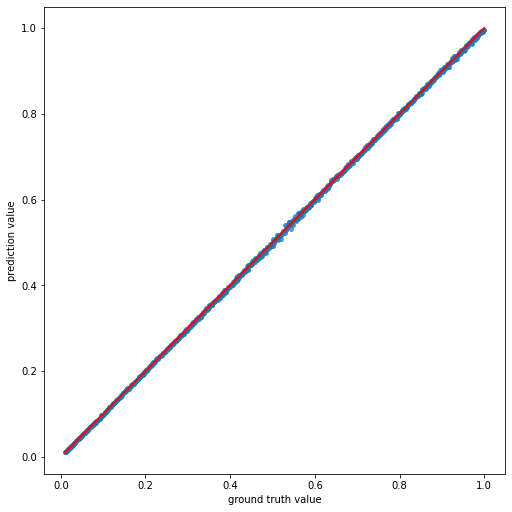

In [36]:
fig, ax = plt.subplots(figsize=(7,7), constrained_layout=True)

plt.rc('axes', labelsize=20)
ax.set_xlabel("ground truth value")
ax.set_ylabel("prediction value")
ax.plot(y_test_fnn, y_test_fnn, color='red', label='linear function prediction=test', linewidth=2.0)
ax.scatter(y_test_fnn, y_pred_t_fnn, label='correlation of responses', alpha=0.7, s=15)